In [1]:
#pip install imbalanced-learn

In [2]:
#pip install xgboost

In [3]:
#pip install scikit-multilearn

In [4]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score
from skmultilearn.model_selection import iterative_train_test_split

#### Reading File

In [5]:
df = pd.read_csv("../data/cleaned_data.csv")

In [6]:
df.head()

,Complaint Id,Tax ID,Officer Days On Force At Incident,Allegation Record Identity,Incident Hour,Precinct Of Incident Occurrence,Total Complaints,Total Substantiated Complaints,year,in_news,...,Current Rank_Chiefs and other ranks,Current Rank_Deputy Inspector,Current Rank_Detective,Current Rank_Inspector,Current Rank_Lieutenant,Current Rank_Police Officer,Current Rank_Sergeant,CCRB Complaint Disposition,PenaltyRecoded,PenaltyCount
0,201903940.0,931819.0,6133.0,1069408.0,7.0,63.0,19.0,1.0,2019.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Unsubstantiated,Not Applicable,Not Applicable
1,201408395.0,915305.0,6989.0,902975.0,5.0,73.0,2.0,1.0,2014.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated,Other,1
2,201408395.0,915305.0,6989.0,902874.0,5.0,73.0,2.0,1.0,2014.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Substantiated,Other,1
3,201902150.0,962844.0,860.0,1064585.0,2.0,42.0,2.0,0.0,2019.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable
4,201902150.0,962844.0,860.0,1064589.0,2.0,42.0,2.0,0.0,2019.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Exonerated,Not Applicable,Not Applicable


#### Setting up X and Y, Splitting Datasets, and SMOTE

In [7]:
#setting up y / complaint
complaint_label_encoder = LabelEncoder()
y = complaint_label_encoder.fit_transform(df["CCRB Complaint Disposition"])

In [8]:
# View the class-to-integer mapping
print("Class to Integer Mapping:", dict(zip(complaint_label_encoder.classes_, range(len(complaint_label_encoder.classes_)))))

Class to Integer Mapping: {'Exonerated': 0, 'Substantiated': 1, 'Unfounded': 2, 'Unsubstantiated': 3}


In [9]:
#setting up x and extracting ys for now
ys = df[["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"]]
x = df.drop(columns = ["CCRB Complaint Disposition", "PenaltyRecoded", "PenaltyCount"])

In [10]:
#training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train, random_state = 3)

In [11]:
#SMOTE for class imbalance
smote = SMOTE(random_state = 10)

In [12]:
#applying SMOTE to training
x_res, y_res = smote.fit_resample(x_train, y_train)

In [13]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

3    3196
1    2381
0     634
2     394
Name: count, dtype: int64
0    3196
1    3196
3    3196
2    3196
Name: count, dtype: int64


### Complaint Models

In [14]:
def model_perf(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()



              precision    recall  f1-score   support

           0       0.13      0.60      0.22       159
           1       0.23      0.01      0.03       595
           2       0.08      0.04      0.05        99
           3       0.53      0.57      0.55       799

    accuracy                           0.34      1652
   macro avg       0.24      0.30      0.21      1652
weighted avg       0.36      0.34      0.30      1652

Balanced Accuracy: 0.30426020730056436
F1-Weighted: 0.2982469221231701
F1-Macro: 0.2110561611246543


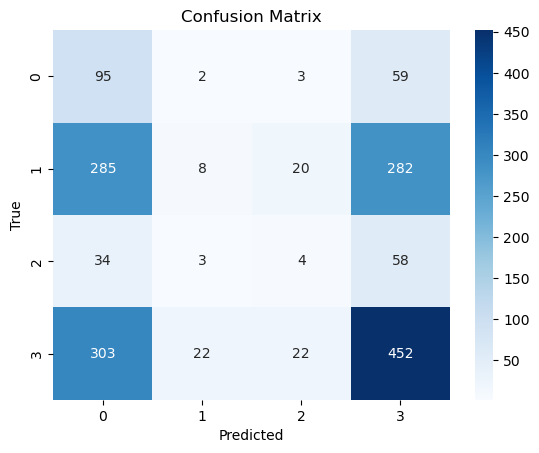

In [15]:
#logistic regression
model_perf("Logistic", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.93      0.45      0.60       159
           1       0.88      0.89      0.89       595
           2       0.88      0.69      0.77        99
           3       0.83      0.93      0.88       799

    accuracy                           0.86      1652
   macro avg       0.88      0.74      0.79      1652
weighted avg       0.86      0.86      0.85      1652

Balanced Accuracy: 0.7396727923435837
F1-Weighted: 0.8489073164327159
F1-Macro: 0.7856406076067762


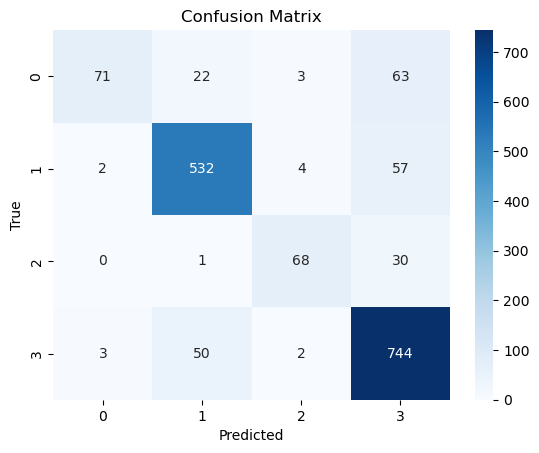

In [16]:
#random forest
model_perf("RF", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.13      0.59      0.21       159
           1       0.00      0.00      0.00       595
           2       0.00      0.00      0.00        99
           3       0.53      0.62      0.57       799

    accuracy                           0.36      1652
   macro avg       0.17      0.30      0.20      1652
weighted avg       0.27      0.36      0.30      1652

Balanced Accuracy: 0.30205406128730095
F1-Weighted: 0.29649033661756335
F1-Macro: 0.1959384448223734


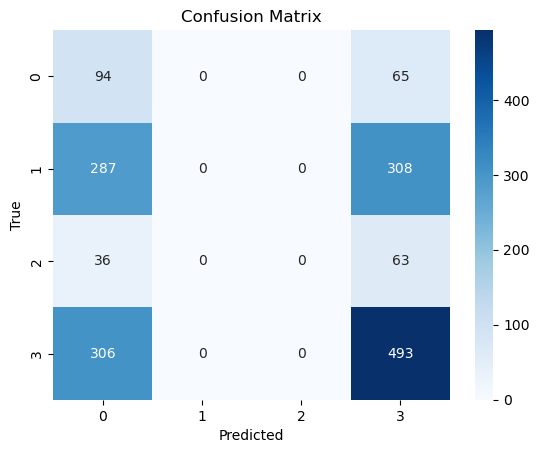

In [17]:
#svm
model_perf("SVM", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.81      0.43      0.57       159
           1       0.89      0.90      0.89       595
           2       0.89      0.75      0.81        99
           3       0.83      0.92      0.87       799

    accuracy                           0.85      1652
   macro avg       0.86      0.75      0.79      1652
weighted avg       0.85      0.85      0.85      1652

Balanced Accuracy: 0.7489709103353517
F1-Weighted: 0.8462913087447516
F1-Macro: 0.7856525062126133


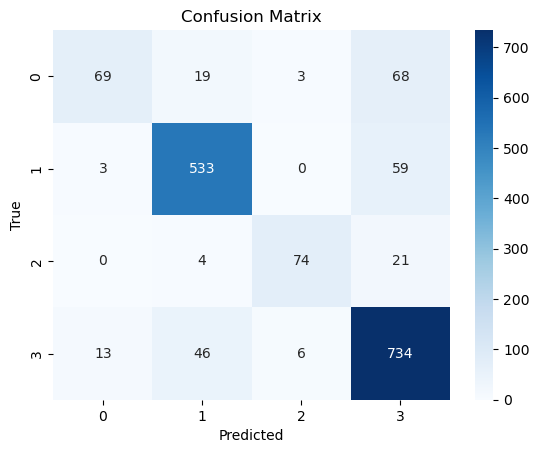

In [18]:
#XGBoost
model_perf("XGB", x_res, y_res, x_valid, y_valid)

              precision    recall  f1-score   support

           0       0.23      0.52      0.31       159
           1       0.61      0.55      0.58       595
           2       0.24      0.59      0.35        99
           3       0.71      0.45      0.55       799

    accuracy                           0.50      1652
   macro avg       0.45      0.53      0.45      1652
weighted avg       0.60      0.50      0.53      1652

Balanced Accuracy: 0.5270046183747272
F1-Weighted: 0.526806527416547
F1-Macro: 0.4478200256938513


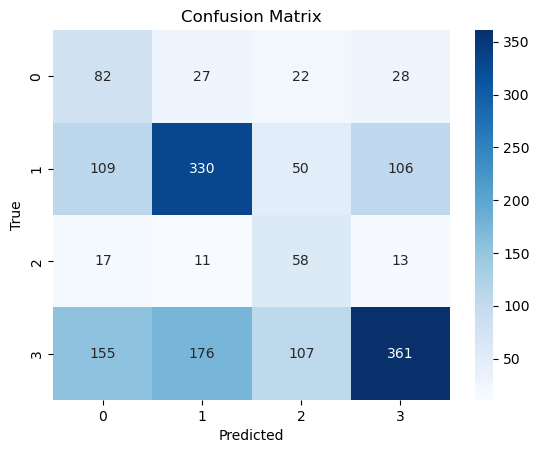

In [19]:
#KNN
model_perf("KNN", x_res, y_res, x_valid, y_valid)

#### Hyperparameter Tuning

In [20]:
#parameter to tune for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [21]:
#initiates rf
rf_tune = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")

In [22]:
#randomized search + cross validation
rf_gs = RandomizedSearchCV(rf_tune, rf_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [23]:
rf_gs.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300]},
                   scoring='f1_weighted')

In [24]:
#performance and best params
print("Best Parameters:", rf_gs.best_params_)
print("Best F1 Score (Weighted):", rf_gs.best_score_)

Best Parameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best F1 Score (Weighted): 0.8941867693639747


In [25]:
#parameters to tune for XG Boost
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [26]:
#initiates xg boost
xgb_tuned = XGBClassifier(objective='multi:softmax', 
                            num_class=4,
                          random_state=2)

In [27]:
#randomized search + cross validation
xgb_sv = RandomizedSearchCV(xgb_tuned, xgb_param_grid, cv = 5,
                     scoring = "f1_weighted",
                     n_jobs = -1)

In [28]:
#fixes columns
x_res.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [29]:
xgb_sv.fit(x_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=4, num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5, 10],
                                        'n_estimators': [50, 100, 200, 250,
                                                         300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='f1_weighted')

In [30]:
#performance and best params
print("Best Parameters:", xgb_sv.best_params_)
print("Best F1 Score (Weighted):", xgb_sv.best_score_)

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted): 0.8941035555552432


#### Final Model Assessment

In [31]:
complaint_mod = RandomForestClassifier(random_state = 2,
                                       class_weight = "balanced",
                                       n_estimators = 300,
                                       min_samples_split = 5,
                                       min_samples_leaf = 1,
                                       max_features = 'log2',
                                       max_depth = 20
                                      )

In [32]:
complaint_mod.fit(x_res, y_res)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_split=5,
                       n_estimators=300, random_state=2)

In [33]:
#compute predicted
x_test.columns = x_test.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred = complaint_mod.predict(x_test)

In [34]:
#performance metrics
complaint_conf_matrix = confusion_matrix(y_test, complaint_pred)
complaint_class_report = classification_report(y_test, complaint_pred, zero_division = 0)
complaint_fl_weighted = f1_score(y_test, complaint_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.91      0.46      0.61       199
           1       0.87      0.91      0.89       744
           2       0.91      0.50      0.65       123
           3       0.84      0.93      0.88       999

    accuracy                           0.85      2065
   macro avg       0.88      0.70      0.76      2065
weighted avg       0.86      0.85      0.84      2065

F1-Weighted: 0.8449702068786573


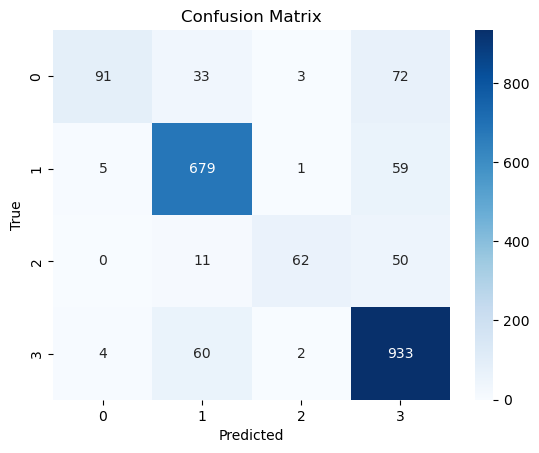

In [35]:
#printing report
print(complaint_class_report)
print(f'F1-Weighted: {complaint_fl_weighted}')

#confusion matrix plot
sns.heatmap(complaint_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

#### Turning Complaints into Binary

In [36]:
#dichotomizing y
bin_y = np.where(ys['CCRB Complaint Disposition'] == "Substantiated",1, 0)

In [37]:
#train test split
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, bin_y, test_size = 0.2, stratify = bin_y, random_state = 3)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train2, y_train2, test_size = 0.2, stratify = y_train2, random_state = 3)

In [38]:
#SMOTE for class imbalance
smote2 = SMOTE(random_state = 10)

#applying SMOTE to training
x_res2, y_res2 = smote2.fit_resample(x_train2, y_train2)

In [39]:
#check class dist
print(pd.Series(y_train2).value_counts())
print(pd.Series(y_res2).value_counts())

0    4224
1    2381
Name: count, dtype: int64
0    4224
1    4224
Name: count, dtype: int64


In [40]:
def model_perf_bin(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #fix col names
    x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

In [41]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic
              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1057
           1       0.39      0.53      0.45       595

    accuracy                           0.53      1652
   macro avg       0.53      0.53      0.52      1652
weighted avg       0.57      0.53      0.54      1652

Balanced Accuracy: 0.5331793644610162
F1-Weighted: 0.542582181325907
F1-Macro: 0.5226211960218807


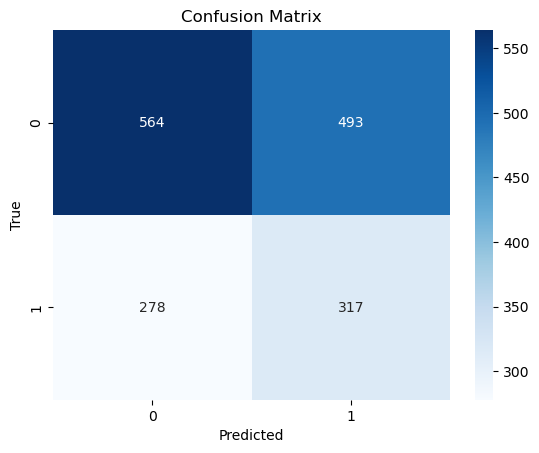

RF
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1057
           1       0.92      0.89      0.90       595

    accuracy                           0.93      1652
   macro avg       0.93      0.92      0.93      1652
weighted avg       0.93      0.93      0.93      1652

Balanced Accuracy: 0.9219377817352106
F1-Weighted: 0.931320077266972
F1-Macro: 0.9252043921524632


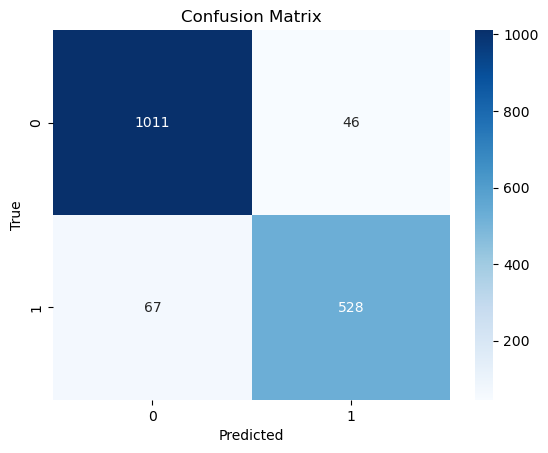

SVM
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1057
           1       0.41      0.44      0.43       595

    accuracy                           0.57      1652
   macro avg       0.54      0.55      0.54      1652
weighted avg       0.58      0.57      0.58      1652

Balanced Accuracy: 0.5454059769603206
F1-Weighted: 0.5767947123879328
F1-Macro: 0.5444015444015444


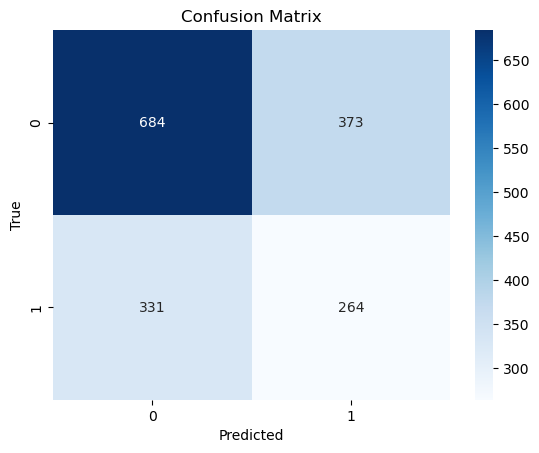

XGB
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1057
           1       0.91      0.90      0.90       595

    accuracy                           0.93      1652
   macro avg       0.93      0.92      0.92      1652
weighted avg       0.93      0.93      0.93      1652

Balanced Accuracy: 0.9240358395013635
F1-Weighted: 0.9309155383797613
F1-Macro: 0.9249713156552779


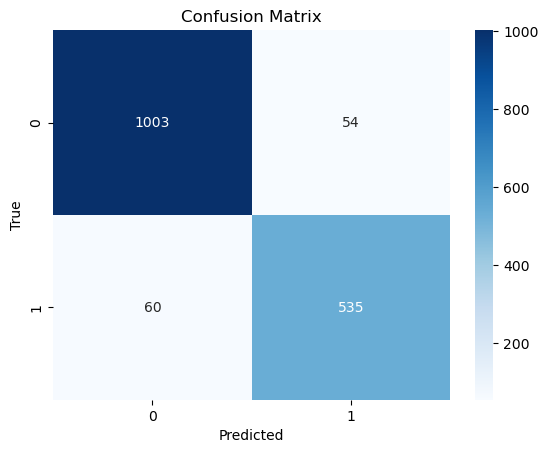

KNN
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1057
           1       0.54      0.65      0.59       595

    accuracy                           0.67      1652
   macro avg       0.66      0.67      0.66      1652
weighted avg       0.69      0.67      0.68      1652

Balanced Accuracy: 0.6661138627636485
F1-Weighted: 0.6770674943708082
F1-Macro: 0.6572220478228579


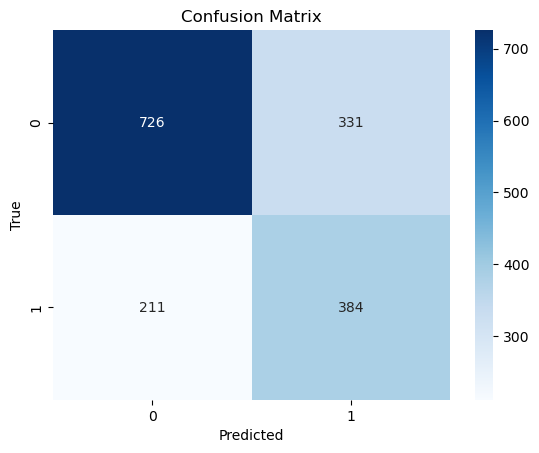

In [42]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_bin(model, x_res2, y_res2, x_valid2, y_valid2)

In [43]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [44]:
top_bin_models = ["RF", "XGB"]

In [45]:
#hyperparameter tuning
for top_mod in top_bin_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='binary:logistic', 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res2, y_res2)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)

Best Parameters for RF: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best F1 Score (Weighted) for RF: 0.9246579507939894


KeyboardInterrupt: 

In [ ]:
#Final Assessment
complaint_mod_bin = XGBClassifier(objective='binary:logistic', 
                              random_state=2,
                              subsample = 1,
                              n_estimators = 200,
                              min_child_weight= 3,
                              max_depth = 9,
                              learning_rate = 0.3,
                              gamma = 0,
                              colsample_bytree = 1.0
                             )


In [ ]:
#fit mod
complaint_mod_bin.fit(x_res2, y_res2)

In [ ]:
#compute predicted
x_test2.columns = x_test2.columns.str.replace(r'[\[\]<>]', '', regex=True)
complaint_pred_bin = complaint_mod_bin.predict(x_test2)

In [ ]:
#performance metrics
complaint_bin_conf_matrix = confusion_matrix(y_test2, complaint_pred_bin)
complaint_bin_class_report = classification_report(y_test2, complaint_pred_bin, zero_division = 0)
complaint_bin_fl_weighted = f1_score(y_test2, complaint_pred_bin, average = 'weighted')

In [ ]:
#printing report
print(complaint_bin_class_report)
print(f'F1-Weighted: {complaint_bin_fl_weighted}')

#confusion matrix plot
sns.heatmap(complaint_bin_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### Penalty Type Models

In [46]:
penalty_df = df.copy().query('PenaltyRecoded != "Not Applicable"')

In [47]:
penalty_df['PenaltyRecoded'].value_counts()

PenaltyRecoded
Formalized Training     671
Command Discipline A    558
Instructions            430
No Penalty              371
Vacation Loss           305
Command Discipline B    146
Other                    58
Name: count, dtype: int64

In [48]:
penalty_df.shape

(2539, 96)

In [49]:
#encoding penalty type
penalty_encoder = LabelEncoder()
y = penalty_encoder.fit_transform(penalty_df['PenaltyRecoded'])

In [50]:
# View the class-to-integer mapping
print("Class to Integer Mapping:", dict(zip(penalty_encoder.classes_, range(len(penalty_encoder.classes_)))))

Class to Integer Mapping: {'Command Discipline A': 0, 'Command Discipline B': 1, 'Formalized Training': 2, 'Instructions': 3, 'No Penalty': 4, 'Other': 5, 'Vacation Loss': 6}


In [52]:
x = penalty_df.drop(columns = ["PenaltyRecoded", "PenaltyCount", "CCRB Complaint Disposition"])

In [53]:
#training, validation, and test sets
x_train3, x_test3, y_train3, y_test3 = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 3)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x_train3, y_train3, test_size = 0.2, stratify = y_train3, random_state = 3)

In [55]:
#SMOTE for class imbalance
smote_penalty = SMOTE(random_state = 10)

#applying SMOTE to training
x_res3, y_res3 = smote_penalty.fit_resample(x_train3, y_train3)

In [56]:
#check class dist
print(pd.Series(y_train3).value_counts())
print(pd.Series(y_res3).value_counts())

2    429
0    357
3    275
4    237
6    195
1     94
5     37
Name: count, dtype: int64
6    429
1    429
4    429
3    429
2    429
0    429
5    429
Name: count, dtype: int64


In [57]:
def model_perf_type(model:str, x_train, y_train, x, y):
    """
    runs and prints model performance
    depending on model argument
    """
    #determine and initialize mode
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, 
                             multi_class = "multinomial",
                             class_weight='balanced',
                             random_state = 2)
    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, 
                                     class_weight='balanced',
                                     random_state = 2)
    elif model == "SVM":
        mod = SVC(kernel='rbf',
                  class_weight='balanced',
                  random_state=2)
    elif model == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors=5)
        
    #fit model
    mod.fit(x_train, y_train)
    
    #compute predicted
    pred = mod.predict(x)
    
    #performance metrics
    conf_matrix = confusion_matrix(y, pred)
    class_report = classification_report(y, pred, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, pred)
    fl_weighted = f1_score(y, pred, average = 'weighted')
    f1_macro = f1_score(y, pred, average = 'macro')
    
    #printing report
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1-Weighted: {fl_weighted}')
    print(f'F1-Macro: {f1_macro}')
    
    #confusion matrix plot
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

In [58]:
#list of models to go through
model_list = ["Logistic", "RF", "SVM", "XGB", "KNN"]

Logistic
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.13      0.09      0.11        23
           2       0.61      0.10      0.17       108
           3       0.26      0.55      0.35        69
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00         9
           6       0.12      0.51      0.20        49

    accuracy                           0.19       407
   macro avg       0.16      0.18      0.12       407
weighted avg       0.23      0.19      0.13       407

Balanced Accuracy: 0.17853387041497065
F1-Weighted: 0.1349903796008264
F1-Macro: 0.11779551672592424


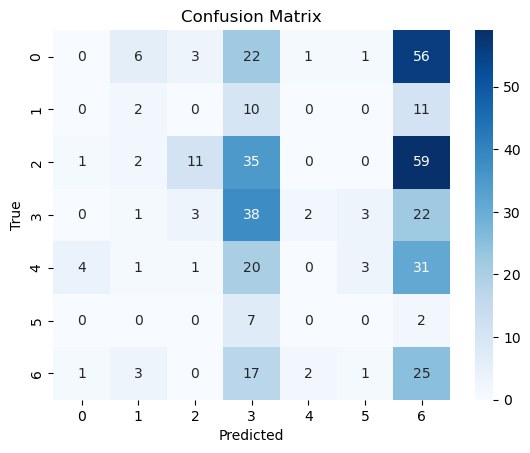

RF
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        89
           1       1.00      0.96      0.98        23
           2       0.92      0.92      0.92       108
           3       0.88      0.91      0.89        69
           4       0.96      0.92      0.94        60
           5       0.89      0.89      0.89         9
           6       0.92      0.90      0.91        49

    accuracy                           0.91       407
   macro avg       0.92      0.91      0.92       407
weighted avg       0.92      0.91      0.91       407

Balanced Accuracy: 0.9142655689767939
F1-Weighted: 0.9142809042129068
F1-Macro: 0.9177625413751758


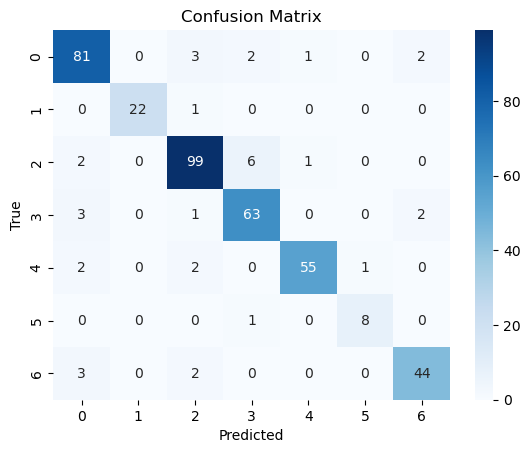

SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00       108
           3       0.23      0.68      0.35        69
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00         9
           6       0.12      0.51      0.20        49

    accuracy                           0.18       407
   macro avg       0.05      0.17      0.08       407
weighted avg       0.05      0.18      0.08       407

Balanced Accuracy: 0.17019478598892973
F1-Weighted: 0.08238177567984589
F1-Macro: 0.07760238482744877


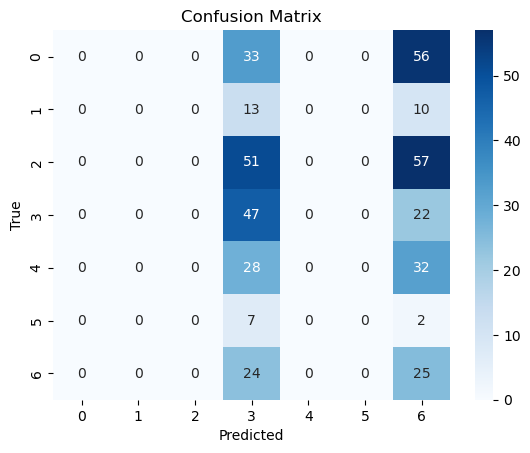

XGB
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        89
           1       1.00      0.96      0.98        23
           2       0.93      0.92      0.93       108
           3       0.91      0.91      0.91        69
           4       0.93      0.92      0.92        60
           5       1.00      0.89      0.94         9
           6       0.86      0.88      0.87        49

    accuracy                           0.91       407
   macro avg       0.93      0.91      0.92       407
weighted avg       0.92      0.91      0.91       407

Balanced Accuracy: 0.9129552535183475
F1-Weighted: 0.9142760550527056
F1-Macro: 0.9216266984530893


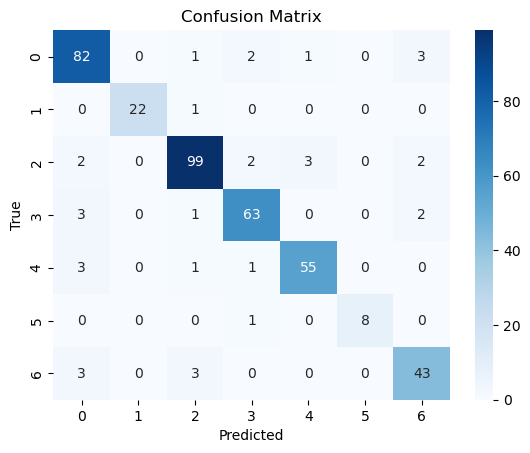

KNN
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        89
           1       0.49      0.83      0.61        23
           2       0.64      0.36      0.46       108
           3       0.56      0.51      0.53        69
           4       0.58      0.63      0.61        60
           5       0.28      0.78      0.41         9
           6       0.49      0.63      0.55        49

    accuracy                           0.55       407
   macro avg       0.52      0.62      0.54       407
weighted avg       0.58      0.55      0.55       407

Balanced Accuracy: 0.6223123064099905
F1-Weighted: 0.5459765041531505
F1-Macro: 0.5414091104952423


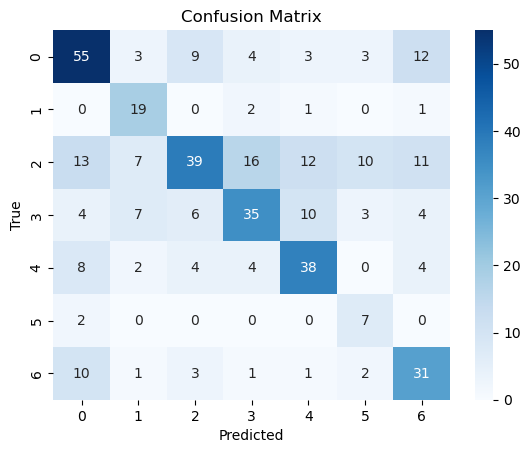

In [59]:
#fits and evaluates performance for each model
for model in model_list:
    print(model)
    model_perf_bin(model, x_res3, y_res3, x_valid3, y_valid3)

In [60]:
#parameter to tune for Random Forest and XGB
params_grid = {
    'RF': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    },
    'XGB': {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
    }
}

In [63]:
top_pen_models = ["RF", "XGB"]

In [66]:
#hyperparameter tuning
for top_mod in top_pen_models:
    #fix cols
    x_res2.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
    
    #initiate mod
    if top_mod == "RF":
        mod = RandomForestClassifier(random_state = 2,
                               class_weight = "balanced")
    elif top_mod == "XGB":
        mod = XGBClassifier(objective='multi:softmax', 
                            num_class=7, 
                            random_state=2)
        
    #randomized grid search
    rf_gs = RandomizedSearchCV(mod, params_grid[top_mod], cv = 5,
                     scoring = "f1_weighted",
                     n_iter = 100,
                     random_state = 42,
                     n_jobs = -1)
    
    #fit
    rf_gs.fit(x_res3, y_res3)
    
    #print best params and scoes
    print(f'Best Parameters for {top_mod}:', rf_gs.best_params_)
    print(f'Best F1 Score (Weighted) for {top_mod}:', rf_gs.best_score_)

Best Parameters for RF: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best F1 Score (Weighted) for RF: 0.9232343105554884
Best Parameters for XGB: {'subsample': 0.7, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1 Score (Weighted) for XGB: 0.9065309369693877


In [69]:
#Final Assessment
penalty_mod = RandomForestClassifier(random_state = 2,
                                     n_estimators = 250, 
                                     min_samples_split= 2, 
                                     min_samples_leaf= 1, 
                                     max_features= 'log2', 
                                     max_depth= None,
                               class_weight = "balanced")

In [70]:
#fit mod
penalty_mod.fit(x_res3, y_res3)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=250, random_state=2)

In [71]:
#compute predicted
x_test3.columns = x_test3.columns.str.replace(r'[\[\]<>]', '', regex=True)
penalty_pred = penalty_mod.predict(x_test3)

In [72]:
#performance metrics
pen_conf_matrix = confusion_matrix(y_test3, penalty_pred)
pen_class_report = classification_report(y_test3, penalty_pred, zero_division = 0)
pen_fl_weighted = f1_score(y_test3, penalty_pred, average = 'weighted')

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       112
           1       1.00      0.93      0.96        29
           2       0.86      0.94      0.90       134
           3       0.94      0.85      0.89        86
           4       0.96      0.96      0.96        74
           5       1.00      1.00      1.00        12
           6       0.96      0.85      0.90        61

    accuracy                           0.91       508
   macro avg       0.94      0.92      0.93       508
weighted avg       0.91      0.91      0.91       508

F1-Weighted: 0.911558707748964


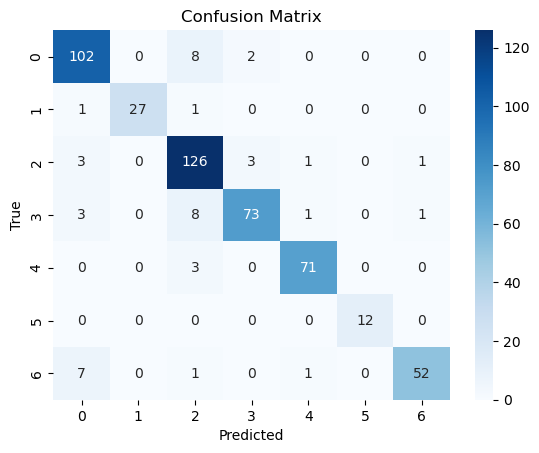

In [73]:
#printing report
print(pen_class_report)
print(f'F1-Weighted: {pen_fl_weighted}')

#confusion matrix plot
sns.heatmap(pen_conf_matrix, annot = True, fmt = "d", cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### Predicting Penalty Count